Done with gears version of norman adata

In [1]:
import os
import sys
from gears import PertData
import pandas as pd
import numpy as np
import torch
from anndata import AnnData

path = os.path.abspath('../sypp/src/gears/')
print(path)
sys.path.insert(0, path)

from mmd_loss import MMDLoss
from scipy.sparse import csr_matrix

/workspace/tfm/sypp/src/gears


In [2]:
!pwd

/workspace/tfm/cris_test


In [3]:
DATA_DIR_PATH = "data"
MODELS_DIR_PATH = "models"
RESULTS_DIR_PATH = "results"

PREDICT_SINGLE = False
PREDICT_DOUBLE = True
PREDICT_COMBO = False

split = "simulation"
seed = 7
hidden_size = 64
device = "cuda:0"
train_model = "gears_norman_split_{}_seed_{}_hidden_size_{}".format(split, str(seed), str(hidden_size))

print("Split: {}".format(split))
print("Seed: {}".format(seed))
print("Hidden size: {}".format(hidden_size))
print("Device: {}".format(device))
print("Model name: {}".format(train_model))

Split: simulation
Seed: 7
Hidden size: 64
Device: cuda:0
Model name: gears_norman_split_simulation_seed_7_hidden_size_64


In [4]:
# Loading norman adata
print("Loading 'norman' data.")
norman = PertData(data_path=DATA_DIR_PATH)
norman.load(data_name="norman")

Found local copy...


Loading 'norman' data.


Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!


In [5]:
# Joining names after cleaning
splitting = norman.adata.obs['condition'].str.split('+')
for i in range(len(splitting)):
  if len(splitting[i]) == 2:
    if 'ctrl' in splitting[i]:
      splitting[i].remove('ctrl')

join_names = splitting.apply(lambda x: '+'.join(sorted(x)))
norman.adata.obs['condition_fixed'] = join_names

print(norman.adata.obs["condition_fixed"].value_counts())

ctrl             7353
KLF1             1641
BAK1             1171
CEBPE            1039
ETS2             1031
                 ... 
PLK4+STIL          66
SAMD1+TGFBR2       59
CEBPB+JUN          52
CBL+UBASH3A        50
C3orf72+FOXL2      49
Name: condition_fixed, Length: 231, dtype: int64


In [6]:
# Keeping only single perturbations
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+") # mask for those NOT containing +
indexes_to_keep = filter_mask[filter_mask].index # mask that finds indeces in norman adata that aren't double perturbations
adata_single = norman.adata[indexes_to_keep].copy()

In [12]:
adata_single.obs['condition_fixed'].value_counts()

ctrl      7353
KLF1      1641
BAK1      1171
CEBPE     1039
ETS2      1031
          ... 
NIT1       165
CDKN1C     165
ZBTB10     145
HES7       122
PLK4        97
Name: condition_fixed, Length: 103, dtype: int64

In [18]:
adata_single

AnnData object with n_obs × n_vars = 54931 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

# Clustering

In [13]:
import scanpy as sc

In [ ]:
sc.pp.scale(adata_single, max_value=10)

714.8568

In [17]:
sc.tl.pca(adata_single, svd_solver='arpack')

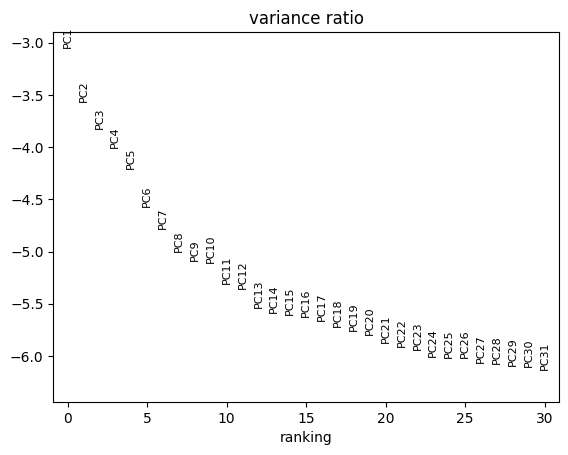

In [19]:
sc.pl.pca_variance_ratio(adata_single, log=True)

In [20]:
sc.pp.neighbors(adata_single, n_neighbors=10, n_pcs=20)

In [21]:
sc.tl.umap(adata_single)

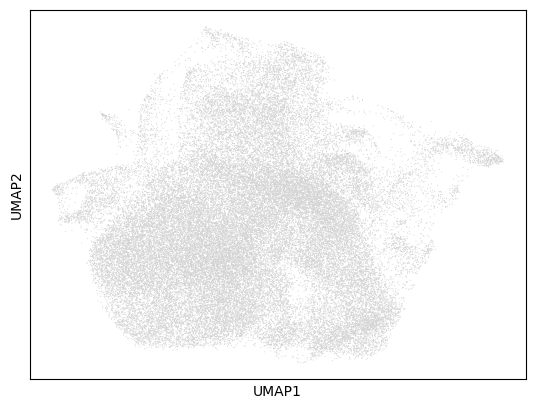

In [22]:
sc.pl.umap(adata_single)

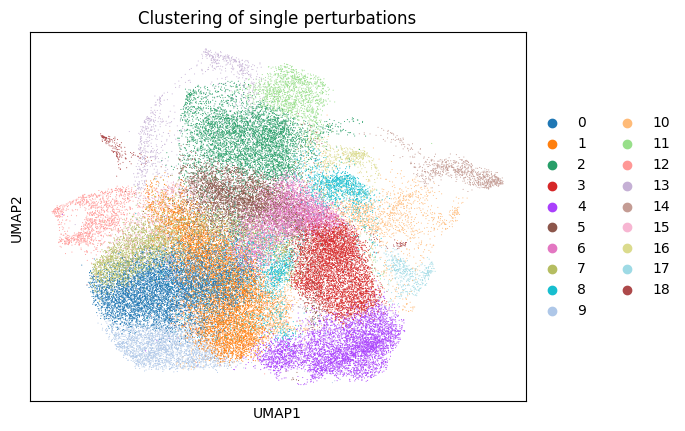

In [33]:
sc.tl.leiden(adata_single)
sc.pl.umap(adata_single, color=['leiden'], title="Clustering of single perturbations")

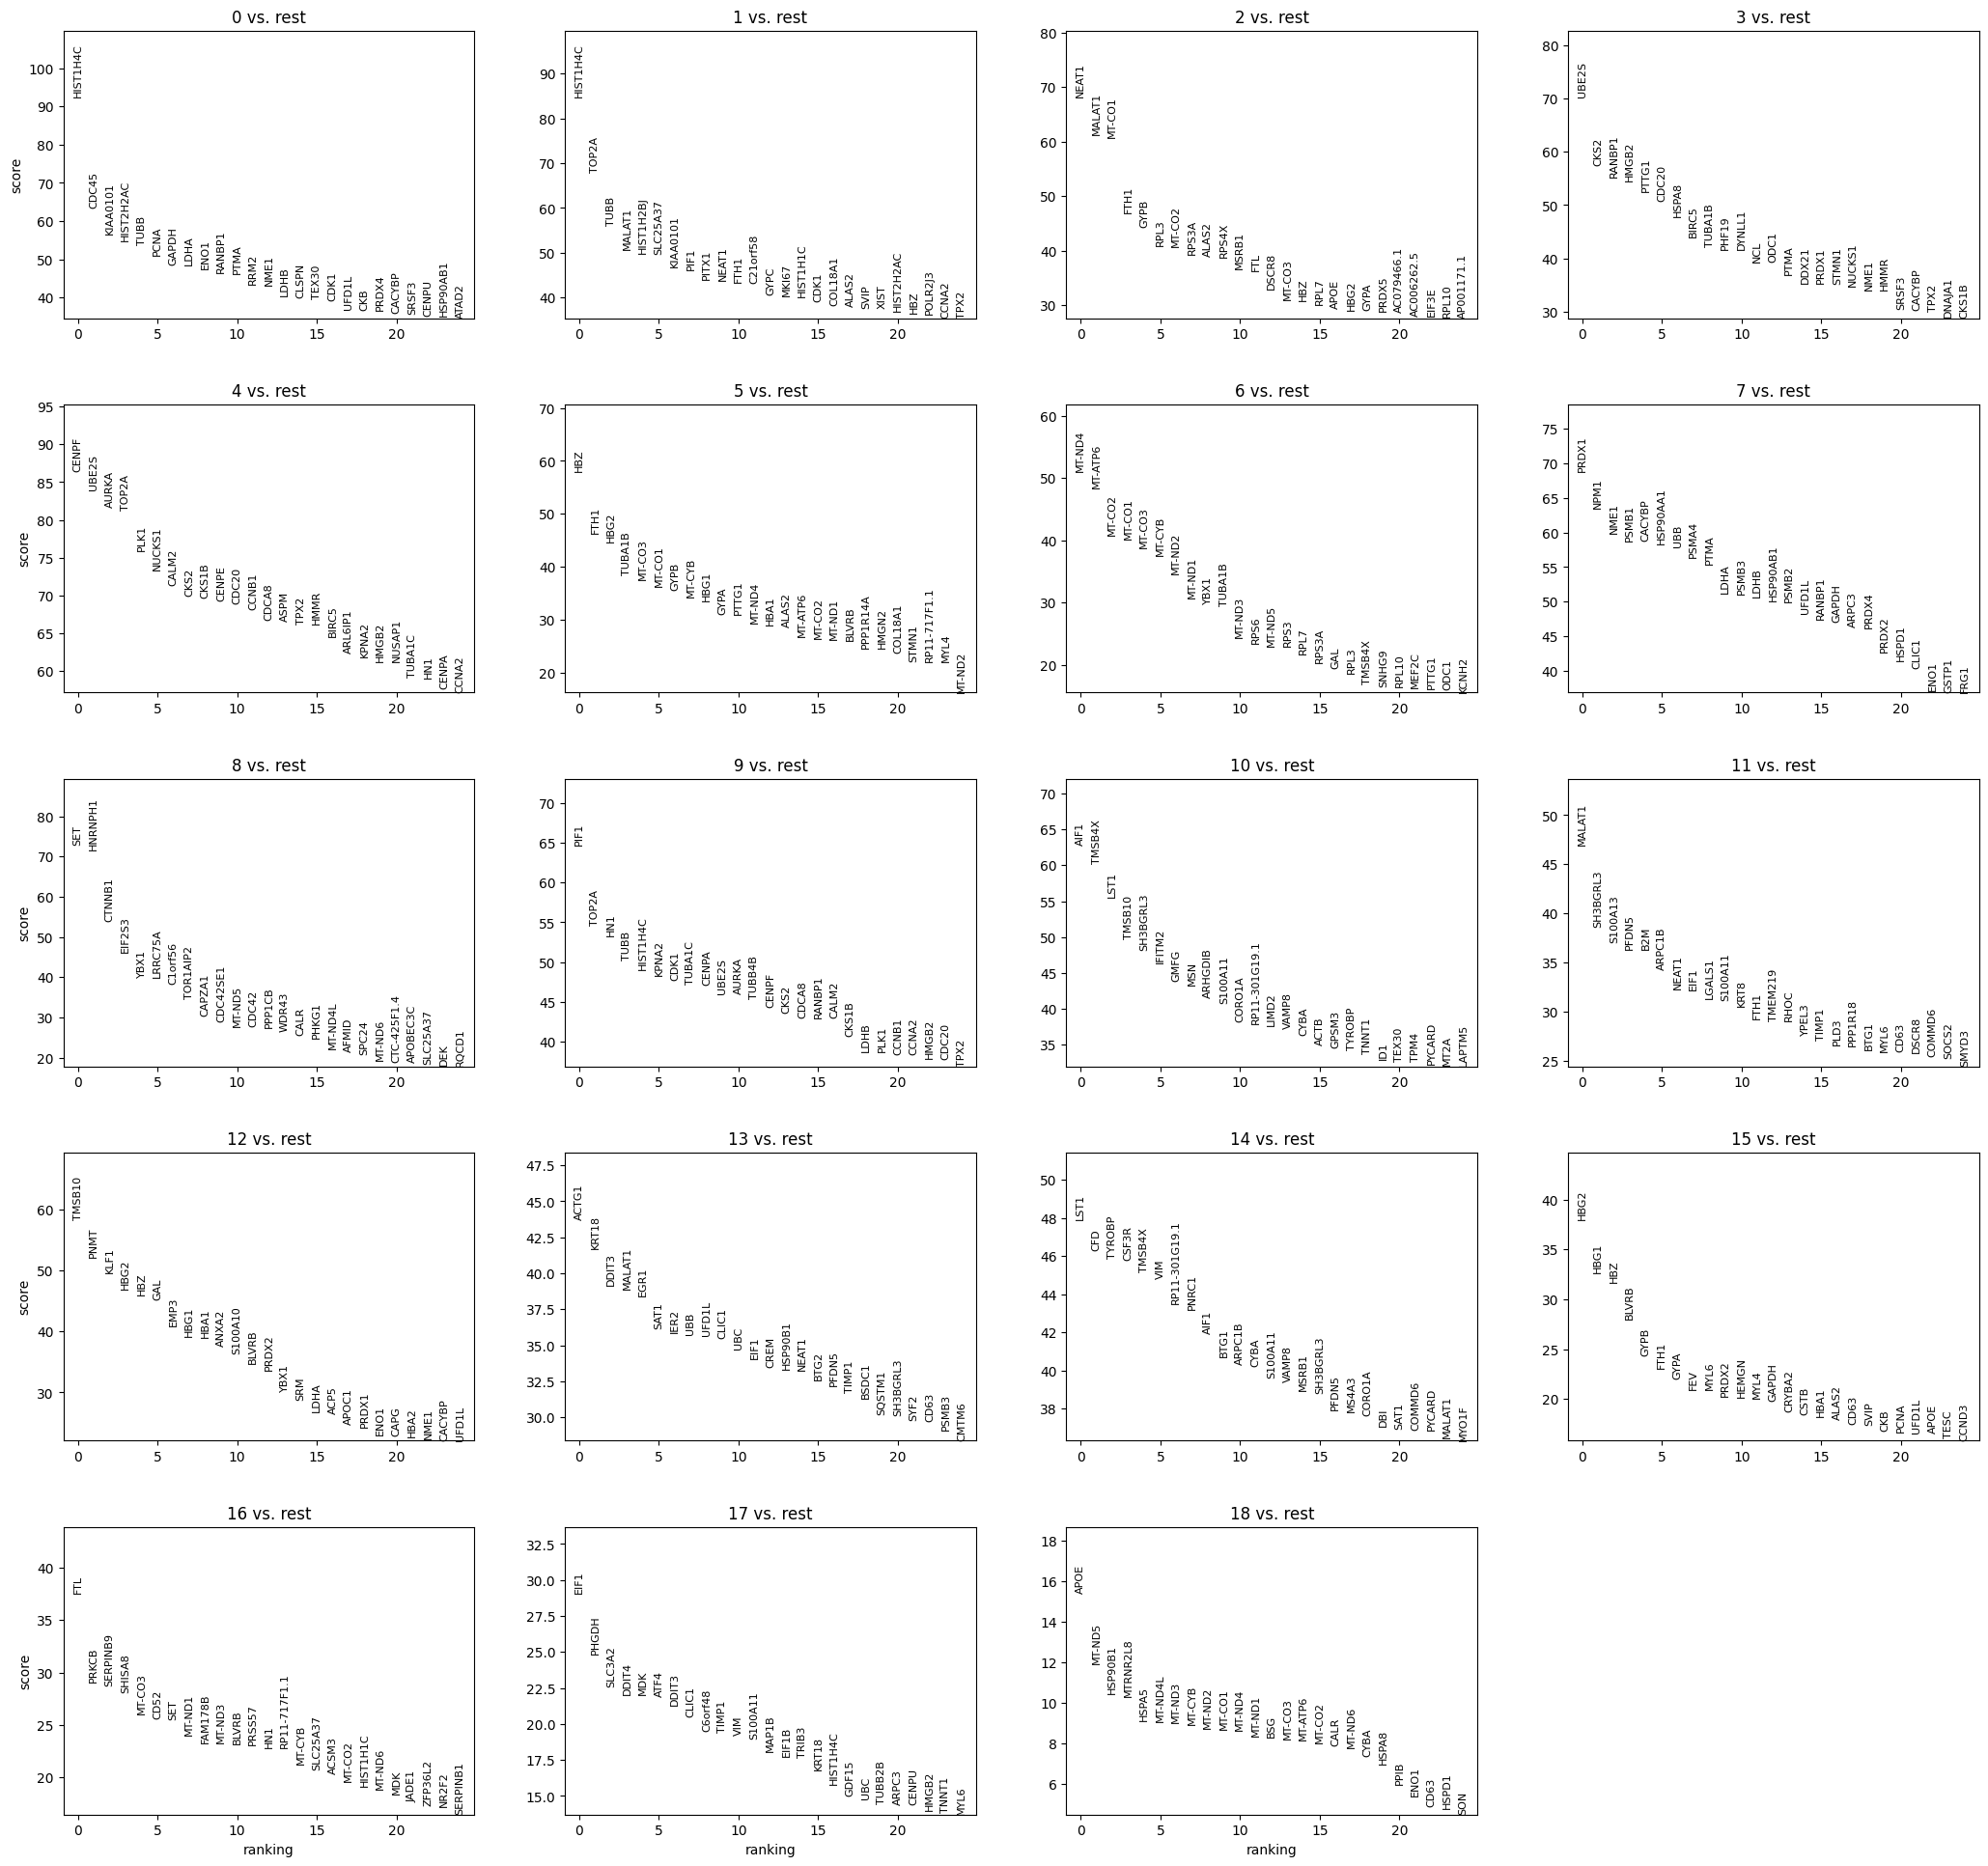

In [32]:
sc.tl.rank_genes_groups(adata_single, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_single, n_genes=25, sharey=False, gene_symbols='gene_name')

In [41]:
adata_control = adata_single[adata_single.obs['condition_fixed'] == 'ctrl'].copy()
adata_control

AnnData object with n_obs × n_vars = 7353 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed', 'leiden'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [40]:
adata_perturb = adata_single[adata_single.obs['condition_fixed'] != 'ctrl'].copy()
adata_perturb

AnnData object with n_obs × n_vars = 47578 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed', 'leiden'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## UMAP for perturbed cells only

In [53]:
adata_single.obs['condition_fixed'].value_counts()

ctrl      7353
KLF1      1641
BAK1      1171
CEBPE     1039
ETS2      1031
          ... 
NIT1       165
CDKN1C     165
ZBTB10     145
HES7       122
PLK4        97
Name: condition_fixed, Length: 103, dtype: int64

In [61]:
condition_counts = adata_single.obs['condition_fixed'].value_counts()
valid_conditions = condition_counts[(condition_counts > 300) & (condition_counts < 2000)].index

In [62]:
adata_perturb = adata_single[adata_single.obs['condition_fixed'].isin(valid_conditions)].copy()

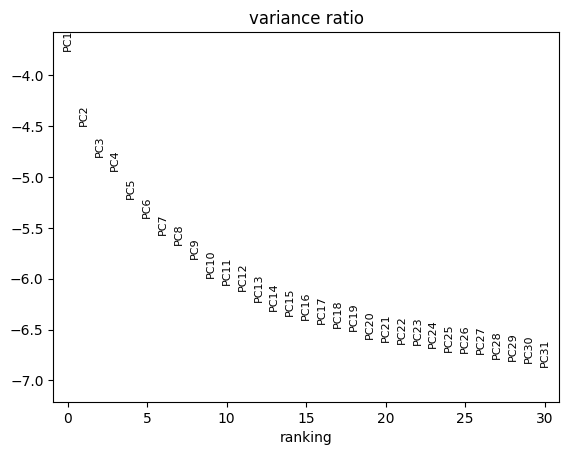

In [63]:
sc.pp.scale(adata_perturb, max_value=10)
sc.tl.pca(adata_perturb, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_perturb, log=True)

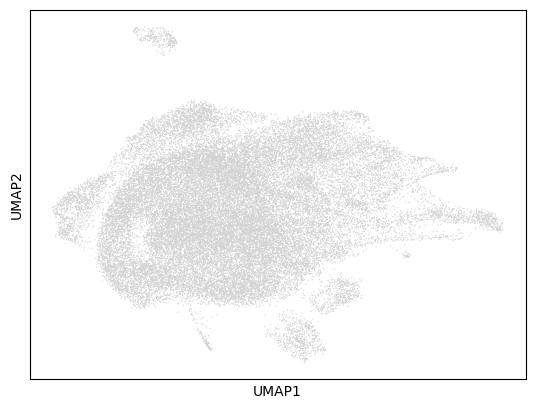

In [64]:
sc.pp.neighbors(adata_perturb, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_perturb)
sc.pl.umap(adata_perturb)

In [65]:
sc.tl.leiden(adata_perturb)

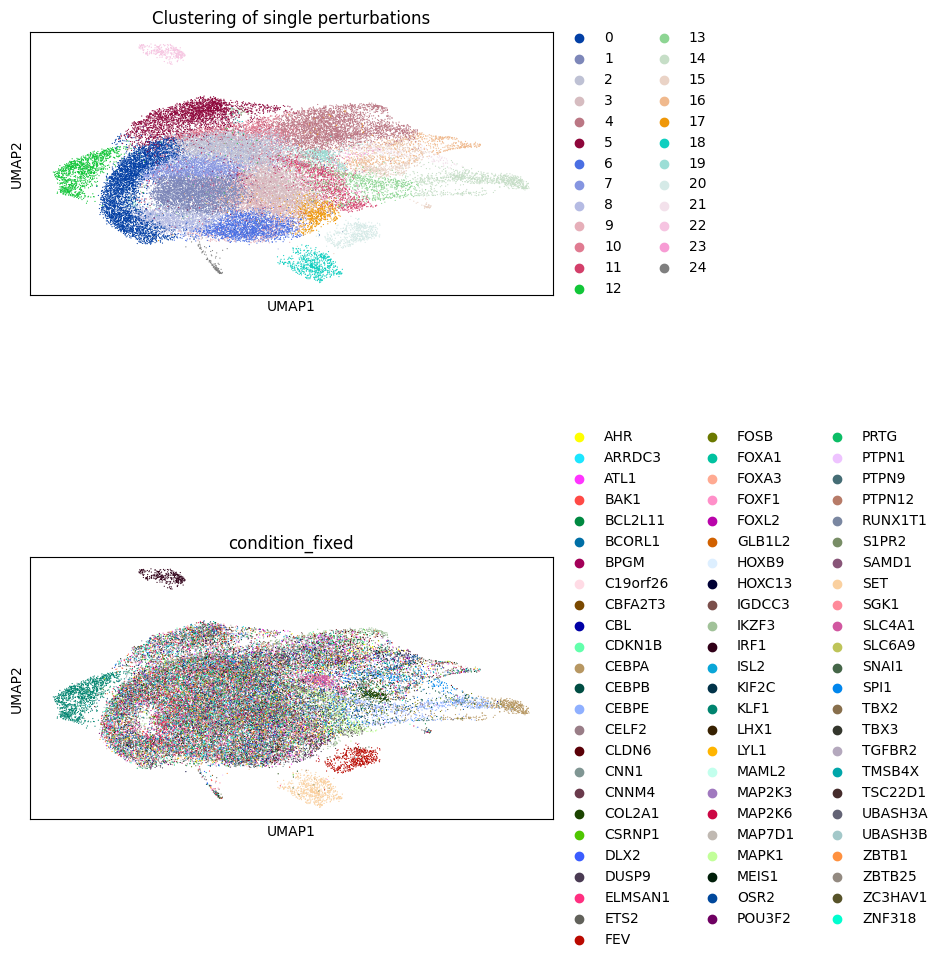

In [66]:
sc.pl.umap(adata_perturb, color=['leiden', 'condition_fixed'], title="Clustering of single perturbations", ncols=1, hspace=1)

In [ ]:
sc.tl.rank_genes_groups(adata_perturb, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_perturb, n_genes=25, sharey=False, gene_symbols='gene_name')

## UMAP for control cells